# NetCDF Analysis 

This notebook examines the temperature at 2m NetCDF grids for an area surrounding Fort MacMurray, Alberta Canada from April 30th to May 4th 2016.

| **Latitude**          | **Longitude**           |
|-----------------------|-------------------------|
| 56.0°N to 57.4°N      | -112.1°W to -110.7°W    |


This grid forms a **14x14 grid** of ERA5-Land cells at a resolution of 0.1° × 0.1° (~9 km per cell).

---

## Dataset Details:
- **Format**: NetCDF  
- **Driver**: GDAL NetCDF  
- **Data Type**: Float32 (32-bit floating point)  
- **Coverage**: Hourly temperature data at 2 meters above ground level.  

In [1]:
import xarray as xr
import os
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import ipywidgets as widgets
from ipywidgets import interact
import numpy as np

### Load and combine data files.

In [2]:
# Define file paths
data_dir = "../data"  # Adjust path to your data folder
file1 = os.path.join(data_dir, "ERA5-land-fort-macmurray-April30.nc")
file2 = os.path.join(data_dir, "ERA5-land-fort-macmurray-May1-2-3.nc")

# Load the datasets
ds1 = xr.open_dataset(file1)
ds2 = xr.open_dataset(file2)

# Combine datasets along the 'valid_time' dimension
combined_ds = xr.concat([ds1, ds2], dim="valid_time")

# Sort the valid_time to ensure continuity (optional, but recommended)
combined_ds = combined_ds.sortby("valid_time")

# Save the combined dataset to a new file
output_file = os.path.join(data_dir, "combined_era5_fort_mcmurray.nc")
combined_ds.to_netcdf(output_file)

print(f"Combined dataset saved to: {output_file}")
print(combined_ds)


Combined dataset saved to: ../data/combined_era5_fort_mcmurray.nc
<xarray.Dataset> Size: 78kB
Dimensions:     (valid_time: 96, latitude: 14, longitude: 14)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 768B 2016-04-30 ... 2016-05-03T23...
  * latitude    (latitude) float64 112B 57.35 57.25 57.15 ... 56.25 56.15 56.05
  * longitude   (longitude) float64 112B -112.0 -112.0 -111.9 ... -110.9 -110.8
    expver      (valid_time) <U4 2kB '0001' '0001' '0001' ... '0001' '0001'
Data variables:
    t2m         (valid_time, latitude, longitude) float32 75kB 290.9 ... 301.5
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-12-12T13:40 GRIB to CDM+CF via cfgrib-0.9.1...


### Create dataframe from combined dataset.

In [3]:
# Load the combined NetCDF file
file_path = "../data/combined_era5_fort_mcmurray.nc"  # Adjust the path if needed
ds = xr.open_dataset(file_path)

# Flatten the dataset: Convert to long-format DataFrame
df = ds["t2m"].to_dataframe().reset_index()

# Rename the temperature column for clarity
df.rename(columns={"t2m": "temperature"}, inplace=True)

# Write DataFrame to CSV for debugging
output_csv_path = "../data/combined_era5_fort_mcmurray_debug.csv"
df.to_csv(output_csv_path, index=False)

# Inspect the DataFrame
print(df.tail())
print(f"DataFrame shape: {df.shape}")
print(f"DataFrame written to: {output_csv_path}")



               valid_time  latitude  longitude  number expver  temperature
18811 2016-05-03 23:00:00     56.05    -111.15       0   0001   300.141663
18812 2016-05-03 23:00:00     56.05    -111.05       0   0001   300.470276
18813 2016-05-03 23:00:00     56.05    -110.95       0   0001   300.920837
18814 2016-05-03 23:00:00     56.05    -110.85       0   0001   301.303223
18815 2016-05-03 23:00:00     56.05    -110.75       0   0001   301.491455
DataFrame shape: (18816, 6)
DataFrame written to: ../data/combined_era5_fort_mcmurray_debug.csv


In [4]:
# Step 1: Clean the DataFrame
# Drop rows where 'temperature' is NaN
df_clean = df.dropna(subset=["temperature"])

# Step 2: Group by latitude and longitude to calculate the temperature range
temperature_range = (
    df_clean.groupby(["latitude", "longitude"])["temperature"]
    .agg(lambda x: x.max() - x.min())  # Calculate range (max - min)
    .reset_index()
    .rename(columns={"temperature": "temp_range"})
)

# Step 3: Find the cell with the maximum temperature range (widest)
max_range_cell = temperature_range.loc[temperature_range["temp_range"].idxmax()]
latitude_max_range = max_range_cell["latitude"]
longitude_max_range = max_range_cell["longitude"]

print(f"Grid cell with the widest temperature range:")
print(f"Latitude: {latitude_max_range}, Longitude: {longitude_max_range}")
print(f"Temperature range: {max_range_cell['temp_range']} K")

# Step 4: Find the cell with the minimum temperature range (narrowest)
min_range_cell = temperature_range.loc[temperature_range["temp_range"].idxmin()]
latitude_min_range = min_range_cell["latitude"]
longitude_min_range = min_range_cell["longitude"]

print(f"\nGrid cell with the narrowest temperature range:")
print(f"Latitude: {latitude_min_range}, Longitude: {longitude_min_range}")
print(f"Temperature range: {min_range_cell['temp_range']} K")

Grid cell with the widest temperature range:
Latitude: 57.35, Longitude: -111.35000000000004
Temperature range: 26.2255859375 K

Grid cell with the narrowest temperature range:
Latitude: 56.05, Longitude: -111.55000000000003
Temperature range: 22.708984375 K


### Plot Temperature Ranges

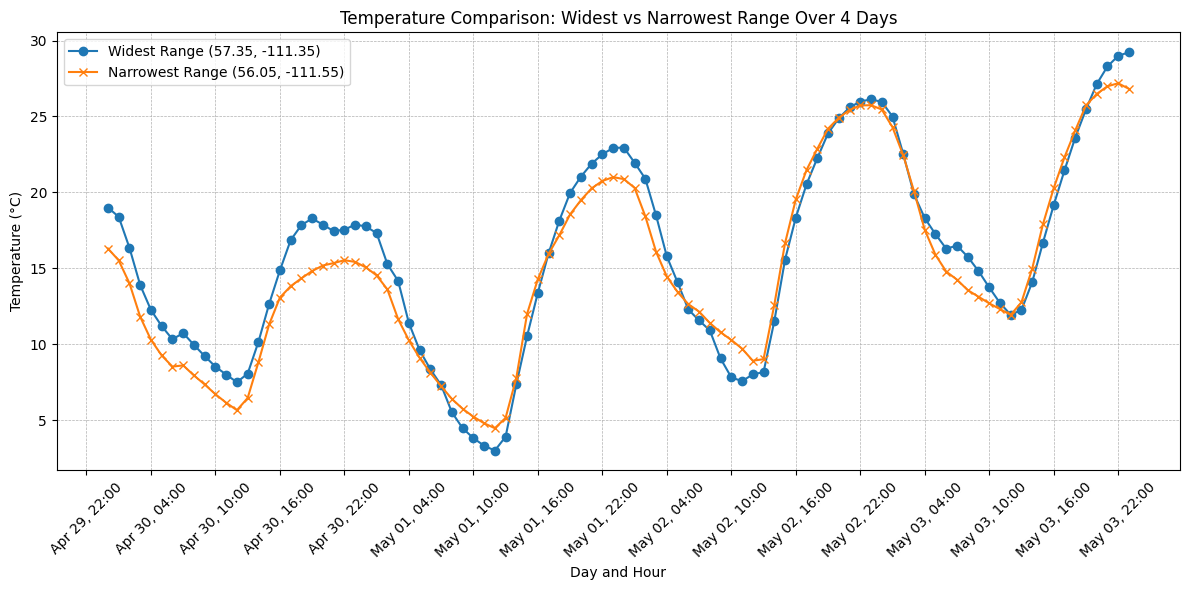

In [5]:
# Step 5: Extract temperature data for the widest temperature range cell
cell_temperature_max = df_clean[
    (df_clean["latitude"] == latitude_max_range) & (df_clean["longitude"] == longitude_max_range)
].copy()

# Extract temperature data for the narrowest temperature range cell
cell_temperature_min = df_clean[
    (df_clean["latitude"] == latitude_min_range) & (df_clean["longitude"] == longitude_min_range)
].copy()

# Convert 'valid_time' to datetime if not already
cell_temperature_max["valid_time"] = pd.to_datetime(cell_temperature_max["valid_time"])
cell_temperature_min["valid_time"] = pd.to_datetime(cell_temperature_min["valid_time"])

# Sort values by valid_time
cell_temperature_max = cell_temperature_max.sort_values(by="valid_time")
cell_temperature_min = cell_temperature_min.sort_values(by="valid_time")

# Convert temperature from Kelvin to Celsius
cell_temperature_max["temperature_c"] = cell_temperature_max["temperature"] - 273.15
cell_temperature_min["temperature_c"] = cell_temperature_min["temperature"] - 273.15

# Step 6: Plot both temperature ranges on the same plot
plt.figure(figsize=(12, 6))

# Plot widest temperature range (Celsius)
plt.plot(
    cell_temperature_max["valid_time"], 
    cell_temperature_max["temperature_c"], 
    linestyle="-", marker="o", color="tab:blue", 
    label=f"Widest Range ({latitude_max_range:.2f}, {longitude_max_range:.2f})"
)

# Plot narrowest temperature range (Celsius)
plt.plot(
    cell_temperature_min["valid_time"], 
    cell_temperature_min["temperature_c"], 
    linestyle="-", marker="x", color="tab:orange", 
    label=f"Narrowest Range ({latitude_min_range:.2f}, {longitude_min_range:.2f})"
)

# X-axis formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %H:%M'))  # Format: 'Month Day, Hour:Minute'
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=6))  # Major ticks every 6 hours
plt.xticks(rotation=45)

# Add titles, labels, and legend
plt.title("Temperature Comparison: Widest vs Narrowest Range Over 4 Days")
plt.xlabel("Day and Hour")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()


### Display sample grid.

### View pre-rendered animation.

In [6]:
from IPython.display import Video

# Path to the video file
video_path = "../data/temperature_grid.mp4"  # Adjust path as needed

# Display the video
Video(video_path, embed=True, width=800, height=600)


### Generate animation.

In [7]:
'''
# File paths
file_path = "../data/combined_era5_fort_mcmurray.nc"
output_folder = "../data/output_grids"
os.makedirs(output_folder, exist_ok=True)

# Load the dataset
ds = xr.open_dataset(file_path)

# Convert temperature from Kelvin to Celsius
ds["t2m_celsius"] = ds["t2m"] - 273.15

# Calculate global temperature min and max across all valid_time steps
temp_min = ds["t2m_celsius"].min().values
temp_max = ds["t2m_celsius"].max().values
print(f"Global Temperature Range (°C): {temp_min:.2f} to {temp_max:.2f}")

# Total valid_time steps
total_steps = ds.dims["valid_time"]

# Loop through all valid_time indices
for frame_index in range(total_steps):
    # Extract the temperature grid for the current valid_time
    grid = ds["t2m_celsius"].isel(valid_time=frame_index)

    # Extract the timestamp for the file name
    time_label = pd.to_datetime(ds["valid_time"].isel(valid_time=frame_index).values)
    time_str = time_label.strftime("%Y%m%d%H%M")

    # Generate the file name
    file_name = f"temperature_grid.{frame_index:04d}.png"
    file_path_out = os.path.join(output_folder, file_name)

    # Plot and save the grid with fixed vmin and vmax
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(
        ds["longitude"], ds["latitude"], grid, cmap="coolwarm",
        vmin=temp_min, vmax=temp_max, shading="auto"
    )
    plt.colorbar(label="Temperature (°C)")
    plt.title(f"Temperature Grid at {time_label.strftime('%Y-%m-%d %H:%M:%S')} (Frame {frame_index})")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.tight_layout()
    plt.savefig(file_path_out, dpi=300)
    plt.close()

    print(f"Saved: {file_name}")
'''


'\n# File paths\nfile_path = "../data/combined_era5_fort_mcmurray.nc"\noutput_folder = "../data/output_grids"\nos.makedirs(output_folder, exist_ok=True)\n\n# Load the dataset\nds = xr.open_dataset(file_path)\n\n# Convert temperature from Kelvin to Celsius\nds["t2m_celsius"] = ds["t2m"] - 273.15\n\n# Calculate global temperature min and max across all valid_time steps\ntemp_min = ds["t2m_celsius"].min().values\ntemp_max = ds["t2m_celsius"].max().values\nprint(f"Global Temperature Range (°C): {temp_min:.2f} to {temp_max:.2f}")\n\n# Total valid_time steps\ntotal_steps = ds.dims["valid_time"]\n\n# Loop through all valid_time indices\nfor frame_index in range(total_steps):\n    # Extract the temperature grid for the current valid_time\n    grid = ds["t2m_celsius"].isel(valid_time=frame_index)\n\n    # Extract the timestamp for the file name\n    time_label = pd.to_datetime(ds["valid_time"].isel(valid_time=frame_index).values)\n    time_str = time_label.strftime("%Y%m%d%H%M")\n\n    # Genera

First grid shape: (14, 14)


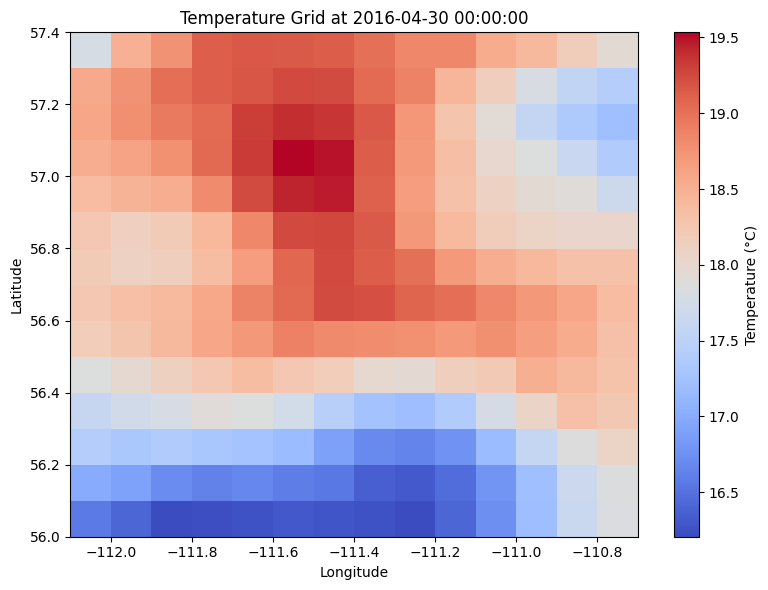

In [8]:
# Load the dataset
file_path = "../data/combined_era5_fort_mcmurray.nc"  # Adjust path as needed
ds = xr.open_dataset(file_path)

# Convert temperature from Kelvin to Celsius
ds["t2m_celsius"] = ds["t2m"] - 273.15

# Extract the first grid: valid_time=0
first_grid = ds["t2m_celsius"].isel(valid_time=0)

# Check grid shape
print("First grid shape:", first_grid.shape)

# Plot the first grid
plt.figure(figsize=(8, 6))
plt.pcolormesh(
    ds["longitude"], ds["latitude"], first_grid, cmap="coolwarm", shading="auto"
)
plt.colorbar(label="Temperature (°C)")

# Add title with timestamp
time_label = pd.to_datetime(ds["valid_time"].isel(valid_time=0).values).strftime(
    "%Y-%m-%d %H:%M:%S"
)
plt.title(f"Temperature Grid at {time_label}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()
